# Basic Data Processing Assignment
## Author: Arkadiusz Modzelewski

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist

In [2]:
######################################################################################################################

def connection(name):
    """
    Set a connection to the database with given name
    
    
    Parameters:
        name(string): name of database
        
    Returns:
        conn(sqlite3.Connection): connection to the database with the given name
    ---   
    """
    conn = sqlite3.connect(name)
    
    return conn


######################################################################################################################

def display_table_names(conn):
    """
    Display names of tables available in database
    
    Parameters:
        conn(sqlite3.Connection): connection to the database
    ---  
    """
    res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    for name in res:
        print(name[0])

        
######################################################################################################################

def create_dataframe(conn, df_ad):
    """
    Creates dataframe required for the task
    
    Parameters:
        conn(sqlite3.Connection): connection to the database
        df_ad(pd.DataFrame): dataframe additional_data from database
        
    Returns:
        df_merged(pd.DataFrame): final dataframe
    ---
    """
    
    df = pd.read_sql_query('Select * From data Inner Join connection on connection.id = data.connection_id', conn)
    df_merged = pd.merge(df, df_ad, left_on='name', right_on='color_name')
    df_merged = df_merged.drop(['id', 'connection_id', 'name'], axis=1)
    
    return df_merged

######################################################################################################################


def display_datatypes(df):
    """
    Displays datatypes of columns
    
    Parameters:
        df(pd.DataFrame): dataframe
    ----
    """
    
    print(df.dtypes)

######################################################################################################################

def change_datatypes(df, name):
    """
    Changes datatypes of given single column
    
    Parameters:
        df(pd.DataFrame): dataframe
        name(string): name of column to change data type
        
    Returns:
        df_merged(pd.DataFrame): final dataframe
    ---
    """
    if name == 'color_id':
        df = df.astype({name: int})
    else:
        df = df.astype({name: float})
    
    return df

######################################################################################################################


def check_missing_data(df):
    """
    Check for any missing data in the df (display in descending order)
    
    Parameters:
        df(pandas.DataFrame): Dataframe
        
    Returns:
        missing(pandas.Series): Series with displayed missing values
    ----
    """
    missing = df.isnull().sum().sort_values(ascending=False)
    return missing

######################################################################################################################


def change_name(df, column, new_name):
    """
    Changes name of single column in dataframe
    
    Parameters:
        df(pandas.DataFrame): Dataframe
        column(string): column for which name should be changed
        new_name(string): new name for given column
        
    Returns:
        df(pandas.DataFrame): final Dataframe
    """
    df = df.rename({column: new_name}, axis=1)
    
    return df

###################################################################################################################### 


def check_unique_values(df, column):
    """
    Check unique values for given column in given dataframe
    
    Parameters:
        df(pandas.DataFrame): Dataframe
    ----
    """
    unique_values = df[column].unique()
    print("Number of unique values:", len(unique_values))
    print("\nUnique values for column", column,":", unique_values)
    

###################################################################################################################### 


def leave_data(df, column, number):
    """
    Leaves only data where value in given column is equal to given number
    
    Parameters:
        df(pandas.DataFrame): Dataframe
        column(string): column name
        number(int, float): number 
        
    Returns:
        df(pandas.DataFrame): final Dataframe
    ---
    """
    
    df = df.loc[df[column] == number]
    return df

######################################################################################################################


def remove_over_sigma(df, number_of_sigma, color):
    """
    Removes data points with a distance from average points’ position for the given color above given number of sigma
    
    Parameters:
        df(pandas.DataFrame): Dataframe
        number_of_sigma(int): number of sigma
        color(string): name of the color 
        
    Returns:
        df(pandas.DataFrame): final Dataframe
    ---   
    """
    
    df_color = df[df['color'] == color]
    x_mean = np.mean(df_color['x'])
    y_mean = np.mean(df_color['y'])
    df_color_copy = df_color.copy()
    df_color_copy.loc[:,'distance'] = np.nan
    
    for it in range(df_color_copy.shape[0]):
        df_color_copy.iloc[it, 5] = dist.euclidean([df_color_copy.iloc[it,0], df_color_copy.iloc[it,1]], [x_mean, y_mean])
    
    std = np.std(df_color_copy['distance'])
    average_dist = np.mean(df_color_copy['distance'])
    
    std_minus = average_dist - (number_of_sigma * std)
    std_plus = average_dist + (number_of_sigma * std)
    
    indexes = df_color_copy.loc[(df_color_copy['distance'] > std_plus) | (df_color_copy['distance'] < std_minus)].index
    
    df_final = df.drop(list(indexes))
    
    return df_final

######################################################################################################################

def save_to_hdf5(df, columns, name):
    """
    Saves given columns in dataframe to hdf5 file with a given name
    
    Parameters:
        df(pandas.DataFrame): Dataframe
        columns(list): list of columns
        name(string): name of the file 
    ---
    """
    
    df[columns].to_hdf(name, key = 'df')


######################################################################################################################

def plot_and_save(df):
    """
    Plots scatter plot for x and y with corresponding color and saves this plot in png file
    
    Parameters:
        df(pandas.DataFrame): Dataframe
    ---
    """
    ax = plt.scatter(df['x'], df['y'], color=[ i for i in df['color'] ])
    plt.title("Smile :)")
    plt.savefig("smile")

In [3]:
conn = connection('database_1.db')

In [4]:
display_table_names(conn)

data
connection
additional_data


In [5]:
data = pd.read_sql_query('Select * From data', conn)
data.head()

,id,x,y,z,connection_id
0,1,44.628947,97.81099110033537,569.700453,105
1,2,40.764309,82.0486367746882,653.904064,76
2,3,25.849509,63.29510234435348,374.171176,72
3,4,18.973396,50.59596955801666,440.976635,239
4,5,44.787622,39.347747208411256,219.388963,152


In [6]:
connection = pd.read_sql_query('Select * From connection', conn)
connection.head()

,id,name
0,2,blue
1,4,blue
2,9,blue
3,10,blue
4,15,blue


In [7]:
additional_data = pd.read_sql_query('Select * From additional_data', conn)
additional_data.head()

,color_id,color_name
0,0,red
1,2,blue
2,3,yellow
3,4,orange
4,5,black


In [8]:
df = create_dataframe(conn, additional_data)
df

,x,y,z,color_id,color_name
0,44.628947,97.81099110033537,569.700453,11,green
1,81.428951,56.675769883299424,30.014223,11,green
2,53.401394,78.05861492878262,291.489162,11,green
3,83.253902,20.349642886980202,835.796016,11,green
4,50.463208,8.814924691205384,492.720476,11,green
...,...,...,...,...,...
101195,24.094444,9.729350550999005,794.632509,2,blue
101196,28.785665,39.27373035902447,251.549429,2,blue
101197,59.562938,28.327137779373334,881.214007,2,blue
101198,56.013233,47.27180576825464,370.917873,2,blue


In [9]:
display_datatypes(df)

x             float64
y              object
z             float64
color_id        int64
color_name     object
dtype: object


In [10]:
df = change_datatypes(df, 'y')

In [11]:
display_datatypes(df)

x             float64
y             float64
z             float64
color_id        int64
color_name     object
dtype: object


In [12]:
check_missing_data(df)

color_name    0
color_id      0
z             0
y             0
x             0
dtype: int64

In [13]:
df = change_name(df, 'color_name', 'color')
df

,x,y,z,color_id,color
0,44.628947,97.810991,569.700453,11,green
1,81.428951,56.675770,30.014223,11,green
2,53.401394,78.058615,291.489162,11,green
3,83.253902,20.349643,835.796016,11,green
4,50.463208,8.814925,492.720476,11,green
...,...,...,...,...,...
101195,24.094444,9.729351,794.632509,2,blue
101196,28.785665,39.273730,251.549429,2,blue
101197,59.562938,28.327138,881.214007,2,blue
101198,56.013233,47.271806,370.917873,2,blue


In [14]:
check_unique_values(df, 'color')

Number of unique values: 6

Unique values for column color : ['green' 'orange' 'yellow' 'red' 'black' 'blue']


In [15]:
df = leave_data(df, 'z', 100)
df

,x,y,z,color_id,color
86,1.127273,0.052112,100.0,11,green
164,0.884848,0.005364,100.0,11,green
655,0.880808,0.007759,100.0,11,green
693,0.828283,0.007381,100.0,11,green
881,0.840404,0.044705,100.0,11,green
...,...,...,...,...,...
101155,0.642643,-0.399358,100.0,2,blue
101160,1.555556,-0.267015,100.0,2,blue
101177,0.314314,-0.469043,100.0,2,blue
101182,1.559560,-0.258990,100.0,2,blue


In [16]:
df_final = remove_over_sigma(df, 1, 'red')
df_final

,x,y,z,color_id,color
86,1.127273,0.052112,100.0,11,green
164,0.884848,0.005364,100.0,11,green
655,0.880808,0.007759,100.0,11,green
693,0.828283,0.007381,100.0,11,green
881,0.840404,0.044705,100.0,11,green
...,...,...,...,...,...
101155,0.642643,-0.399358,100.0,2,blue
101160,1.555556,-0.267015,100.0,2,blue
101177,0.314314,-0.469043,100.0,2,blue
101182,1.559560,-0.258990,100.0,2,blue


In [17]:
df_final.reset_index(drop=True, inplace=True)
df_final

,x,y,z,color_id,color
0,1.127273,0.052112,100.0,11,green
1,0.884848,0.005364,100.0,11,green
2,0.880808,0.007759,100.0,11,green
3,0.828283,0.007381,100.0,11,green
4,0.840404,0.044705,100.0,11,green
...,...,...,...,...,...
1153,0.642643,-0.399358,100.0,2,blue
1154,1.555556,-0.267015,100.0,2,blue
1155,0.314314,-0.469043,100.0,2,blue
1156,1.559560,-0.258990,100.0,2,blue


In [18]:
save_to_hdf5(df_final, ['x','y','color'], 'ns1.h5')

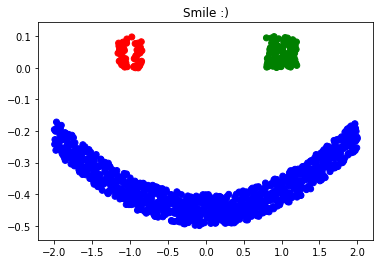

In [19]:
plot_and_save(df_final)